In [1]:
%matplotlib inline
import sys
# initialize stuff
if sys.platform == 'darwin':
    plat = 'usb'
    # plat = 'mac'
    sys.path.append('/Users/njchiang/GitHub/LanguageMVPA/multivariate/python/analysis')
    sys.path.append('/Users/njchiang/GitHub/python-fmri-utils/utils')
    debug = True
else:
    plat = 'win'
    sys.path.append('D:\\GitHub\\LanguageMVPA\\multivariate\\python\\analysis')
    sys.path.append('D:\\GitHub\\python-fmri-utils\\utils')
    debug = False
import lmvpautils as lmvpa
paths, subList, contrasts, maskList = lmvpa.initpaths(plat)

Initializing...


In [2]:
# parameters
sub = 'LMVPA005'
roi = "left_IFG_operc"
betatype = 'tstat'
con = "syntax"
chance = .25
filterLen = 49
filterOrd = 2
dsType = "Lang"
nVox = 500

In [3]:
# load raw data
thisSub = {sub: subList[sub]}
mc_params = lmvpa.loadmotionparams(paths, thisSub)
beta_events = lmvpa.loadevents(paths, thisSub)
dsdict = lmvpa.loadsubdata(paths, thisSub, m=roi, c='trial_type')
thisDS = dsdict[sub]

loading LMVPA005


C:\Python27\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [4]:
# preprocess raw data
import SavGolFilter as sg
sg.sg_filter(thisDS, filterLen, filterOrd)
from mvpa2.mappers.zscore import zscore
zscore(thisDS, chunks_attr='chunks')

In [5]:
# beta extract raw data
rds, events = lmvpa.amendtimings(thisDS.copy(), beta_events[sub], contrasts)  # adding features

import mvpa2.datasets.eventrelated as er
evds = er.fit_event_hrf_model(rds, events, time_attr='time_coords',
                              condition_attr=('trial_type', 'chunks'),
                              design_kwargs={'add_regs': mc_params[sub], 'hrf_model': 'canonical'},
                              return_model=True)
fds = lmvpa.replacetargets(evds, contrasts, con)
fds = fds[fds.targets != '0']

In [6]:
# load betas
bds = lmvpa.loadsubbetas(paths, sub, btype=betatype, m=roi)

LMVPA005


In [7]:
# preprocess betas
zscore(bds, chunks_attr='chunks')
bds.sa['targets'] = bds.sa[con]

In [8]:
# set analysis idx
flidx = fds.chunks < fds.sa['chunks'].unique[len(fds.sa['chunks'].unique)/2]
fpidx = fds.chunks >= fds.sa['chunks'].unique[len(fds.sa['chunks'].unique) / 2]
blidx = bds.sa['stim'].value == 's'

In [9]:
# initialize classifier
from mvpa2.clfs import svm
clf = svm.LinearCSVMC()
from mvpa2.clfs.warehouse import OneWayAnova
fsel = OneWayAnova()
import mvpa2.featsel as fs
fselector = fs.helpers.FixedNElementTailSelector(nVox, tail='upper',
                                                 mode='select', sort=False)
# fselector = fs.helpers.FractionTailSelector(0.05, mode='select', tail='upper')
sbfs = fs.base.SensitivityBasedFeatureSelection(fsel, fselector,
                                                enable_ca=['sensitivities'])
from mvpa2.clfs.meta import FeatureSelectionClassifier
fclf = FeatureSelectionClassifier(clf, sbfs)

from mvpa2.measures.base import CrossValidation
from mvpa2.misc import errorfx
from mvpa2.generators.partition import NFoldPartitioner
cv = CrossValidation(fclf,
                     NFoldPartitioner(attr='chunks'),
                     errorfx=errorfx.mean_match_accuracy)

In [10]:
#SVM
import numpy as np
bres = cv(bds[blidx].copy())
print "beta mean: " + str(np.mean(bres))
cv.untrain()
fres = cv(fds[flidx].copy())
print "from raw mean: " + str(np.mean(fres))

beta mean: 0.1875
from raw mean: 0.25


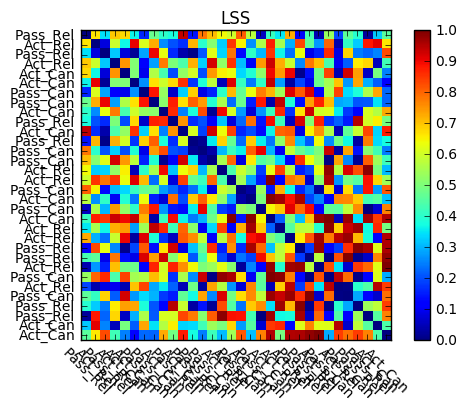

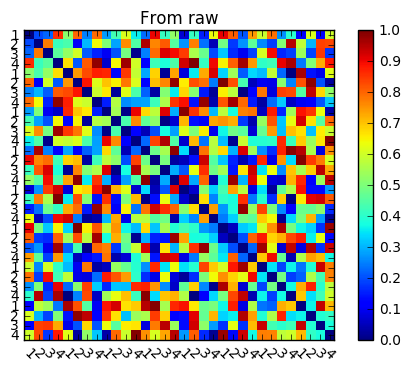

In [12]:
from mvpa2.measures import rsa
dsm = rsa.PDist(square=True)
frsares = dsm(fds[flidx].copy())
brsares = dsm(bds[blidx].copy())
import rsautils as ru
bf, bax = ru.plot_mtx(ru.rankTransform(brsares), bds[blidx].sa.targets, 'LSS')
ff, fax = ru.plot_mtx(ru.rankTransform(frsares), fds[flidx].sa.targets, 'From raw')